# Handwritten Number Recognition
 

*Author:* Marina García Guijarro

*Dataset:* MNIST

*Framework:* PyTorch

*Note:* This personal project was done with the only purpose of learning. Hence, the recurrent comments and links to useful online sites.

## 1. Import libraries

In [3]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

### GPU Check

In [4]:
torch.cuda.get_device_name(0), torch.cuda.is_available()

('NVIDIA GeForce RTX 3050 Laptop GPU', True)

## 2. Import dataset

PyTorch provides two data primitives: 
- torch.utils.data.Dataset - to use preloaded datasets
- torch.utils.data.DataLoader - includes an iterable for easier access

https://pytorch.org/vision/main/datasets.html 

In [5]:
mydir = 'C:/Users/marin/code/MNISTClassification' # change as needed

In [6]:
# https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html

# mnist dataset downloaded to directory if it does not already exist
# train = True will created ds from train-images-idx3-ubyte
# train = False will create ds from t10k-images-idx3-ubyte

trainset = torchvision.datasets.MNIST(mydir,download=True,train=True,transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(mydir,download=True,train=False,transform=torchvision.transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle= True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle= True)

## 3. Explore data

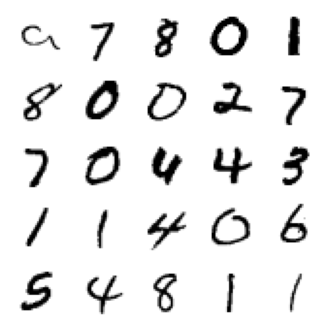

In [7]:
train_features, train_labels = next(iter(trainloader))
figure = plt.figure(figsize=(4,4))

rows, cols = 5, 5

for i in range(1,rows*cols + 1):
    figure.add_subplot(rows,cols,i)
    #plt.title(train_labels[i])
    plt.axis("off")
    plt.imshow(train_features[i].squeeze(),cmap="gray_r")
plt.show()


Each bach contains: 64 examples
Each example has size 28 x 28
Values in image range from 0.0 to 1.0


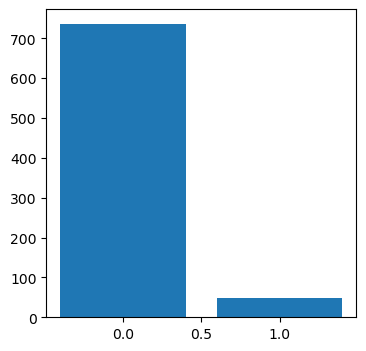

In [8]:
train_features.size()
print(f"Each bach contains: {train_features.size(0)} examples")
print(f"Each example has size {train_features.size(2)} x {train_features.size(3)}")
bins = 2
hist = torch.histogram(train_features[1],bins=bins)
print(f"Values in image range from {hist.bin_edges[0]} to {hist.bin_edges[bins]}")
plt.figure(figsize=(4,4))
plt.bar(range(bins),hist.hist)
plt.show()

## 4. Data Transformation
Pixel values 0 or 1. I now normalize this distribution. 

In [9]:
# tranformed_value = (input - mean)/std

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,),(0.5,))
                                            ])

# Reload data, now transformed 

trainset = torchvision.datasets.MNIST(mydir,download=True,train=True,transform=transform)
testset = torchvision.datasets.MNIST(mydir,download=True,train=False,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle= True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle= True)

In [10]:
train_features, train_labels = next(iter(trainloader))
bins = 2
hist = torch.histogram(train_features[1],bins=bins)
print(f"Values in image range from {hist.bin_edges[0]} to {hist.bin_edges[bins]}")

Values in image range from -1.0 to 1.0


## 5. Neural Network

In [51]:
from torch import nn

class myNN(nn.Module):

    def __init__(self,inodes,hnodes,onodes,lr):
        super().__init__()

        # dimesions
        self.inodes = inodes
        self.hnodes = hnodes
        self.onodes = onodes

        # learning rate
        self.lr = lr

        # feed-forward linear model with one hidden layer
        self.linear_ih =nn.Linear(inodes, hnodes, bias = False)
        self.linear_h0 = nn.Linear (hnodes, onodes, bias = False)

        # activation function: Sigmoid
        self.actfun = nn.ReLU()

        self.model = nn.Sequential(self.linear_ih,
                              self.actfun,
                              self.linear_h0,
                              self.actfun,
                              nn.LogSoftmax(dim = 1))
        
        # error function: NLLLoss
        self.errfun = nn.NLLLoss()

        # optimizer: require parameters to optimize and learning rate
        self.optimizer = torch.optim.SGD(self.parameters(),self.lr,momentum = 0.5)

        pass

    def forward(self,im_input):

        # reshape the input image into a 1D tensor of all pixel values
        inputs = im_input.view(im_input.shape[0],self.inodes)

        outputs = self.model(inputs)
        
        return outputs

    def train(self, inputs, targets):

        outputs = self.forward(inputs)

        self.loss = self.errfun(outputs,targets)

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        
        pass

    pass

Se NLLLoss for classification models https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html 

## 6. Explore NN

In [44]:
images, labels = next(iter(trainloader))

NN = myNN(images.size(2)*images.size(3),128,10,0.1)
NN.cuda()
NN.train(images.cuda(),labels.cuda())


2.3008503913879395
2.3008503913879395


## 7. Train NN

In [52]:
images, labels = next(iter(trainloader))

NN = myNN(images.size(2)*images.size(3),128,10,0.1)
NN.cuda()

epochs = 15

for e in range(epochs):
    for images, labels in trainloader:
        NN.train(images.cuda(),labels.cuda())
    else: 
        print (f"Epoch {e}: Current loss is {NN.loss.item()}")
    

Epoch 0: Current loss is 0.5546095967292786
Epoch 1: Current loss is 0.4487592279911041
Epoch 2: Current loss is 0.7291951179504395
Epoch 3: Current loss is 0.4034140408039093
Epoch 4: Current loss is 0.10628005117177963
Epoch 5: Current loss is 0.009263847954571247
Epoch 6: Current loss is 0.00922919251024723
Epoch 7: Current loss is 0.22088538110256195
Epoch 8: Current loss is 0.02926580235362053
Epoch 9: Current loss is 0.004875339567661285
Epoch 10: Current loss is 0.03017381578683853
Epoch 11: Current loss is 0.09213319420814514
Epoch 12: Current loss is 0.0021393506322056055
Epoch 13: Current loss is 0.014924680814146996
Epoch 14: Current loss is 0.004971057642251253


## 8. View Results